In [1]:
# Cell 1: Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import wfdb
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Add parent directory to path
sys.path.append('..')
from src import data_processing, peak_detection, feature_extraction, arrhythmia_classifier

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12


In [4]:
# %% Cell 2: Load MIT-BIH Database
# Path to MIT-BIH database
data_dir = '../data/raw'  # Update with your path

# Check if the directory exists
if not os.path.exists(data_dir):
    print(f"Directory not found: {data_dir}")
    print("Please download the MIT-BIH Arrhythmia Database and specify the correct path.")
    print("You can download it from: https://physionet.org/content/mitdb/1.0.0/")
else:
    # Load all records with annotations
    record_data = arrhythmia_classifier.load_all_records_with_annotations(data_dir)
    
    # Print summary of loaded records
    print(f"Loaded {len(record_data)} records from MIT-BIH database")
    
    # Get total number of annotated beats
    total_beats = 0
    for record_name, data in record_data.items():
        if 'annotation' in data and data['annotation'] is not None:
            total_beats += len(data['annotation'].symbol)
    
    print(f"Total number of annotated beats: {total_beats}")

Successfully loaded 100
Successfully loaded 101
Successfully loaded 102
Successfully loaded 103
Successfully loaded 104
Successfully loaded 105
Successfully loaded 106
Successfully loaded 107
Successfully loaded 108
Successfully loaded 109
Successfully loaded 111
Successfully loaded 112
Successfully loaded 113
Successfully loaded 114
Successfully loaded 115
Successfully loaded 116
Successfully loaded 117
Successfully loaded 118
Successfully loaded 119
Successfully loaded 121
Successfully loaded 122
Successfully loaded 123
Successfully loaded 124
Successfully loaded 200
Successfully loaded 201
Successfully loaded 202
Successfully loaded 203
Successfully loaded 205
Successfully loaded 207
Successfully loaded 208
Successfully loaded 209
Successfully loaded 210
Successfully loaded 212
Successfully loaded 213
Successfully loaded 214
Successfully loaded 215
Successfully loaded 217
Successfully loaded 219
Successfully loaded 220
Successfully loaded 221
Successfully loaded 222
Successfully loa

Beat Type Distribution:
Normal: 90631 (82.77%)
Ventricular Premature: 7236 (6.61%)
Paced: 7028 (6.42%)
Atrial Premature: 2781 (2.54%)
Fusion: 1785 (1.63%)
Unclassifiable: 33 (0.03%)


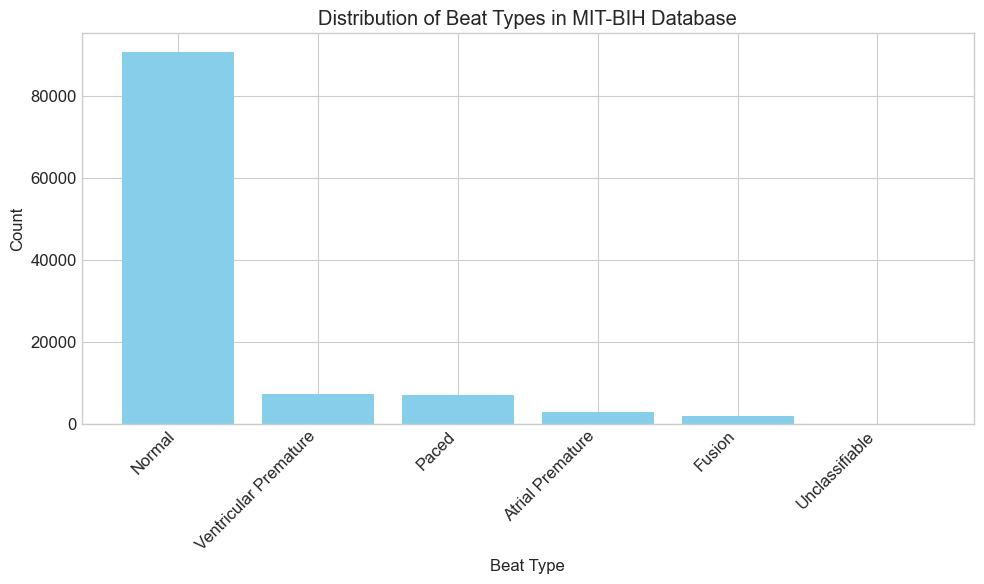

In [5]:
# %% Cell 3: Examine Annotation Distribution
# Create a dictionary to count beat types
beat_types = Counter()

for record_name, data in record_data.items():
    if 'annotation' not in data or data['annotation'] is None:
        continue
    
    symbols = data['annotation'].symbol
    
    for symbol in symbols:
        if symbol in arrhythmia_classifier.AAMI_MAPPING:
            beat_class = arrhythmia_classifier.AAMI_MAPPING[symbol]
            beat_types[beat_class] += 1

# Print beat type distribution
print("Beat Type Distribution:")
for beat_class, count in beat_types.most_common():
    print(f"{beat_class}: {count} ({count/sum(beat_types.values())*100:.2f}%)")

# Plot beat type distribution
plt.figure(figsize=(10, 6))
classes, counts = zip(*beat_types.most_common())
plt.bar(classes, counts, color='skyblue')
plt.title('Distribution of Beat Types in MIT-BIH Database')
plt.xlabel('Beat Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Extracted 109452 labeled heartbeats
Label distribution: Counter({np.int64(0): 90594, np.int64(2): 7235, np.int64(4): 7025, np.int64(1): 2781, np.int64(3): 1784, np.int64(5): 33})


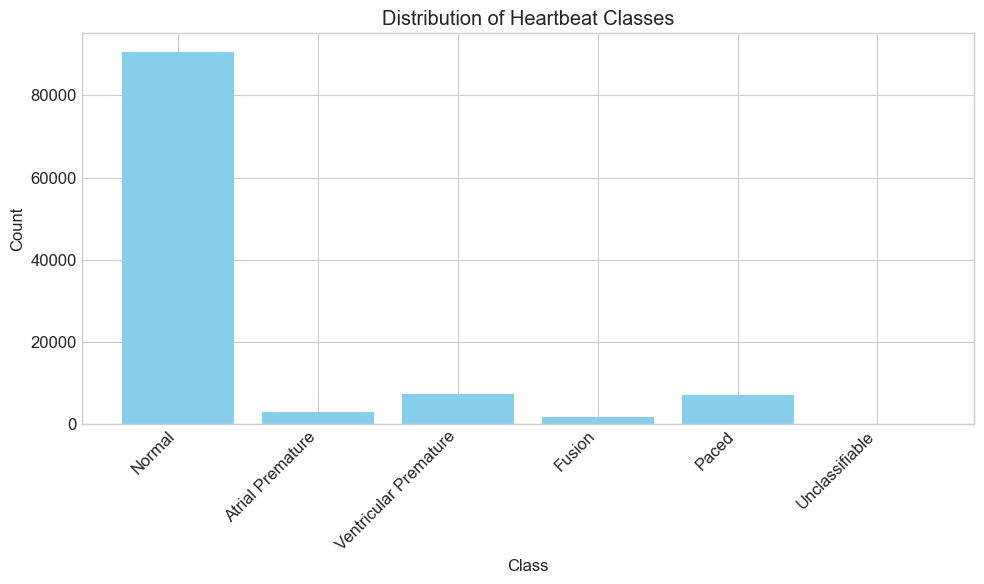

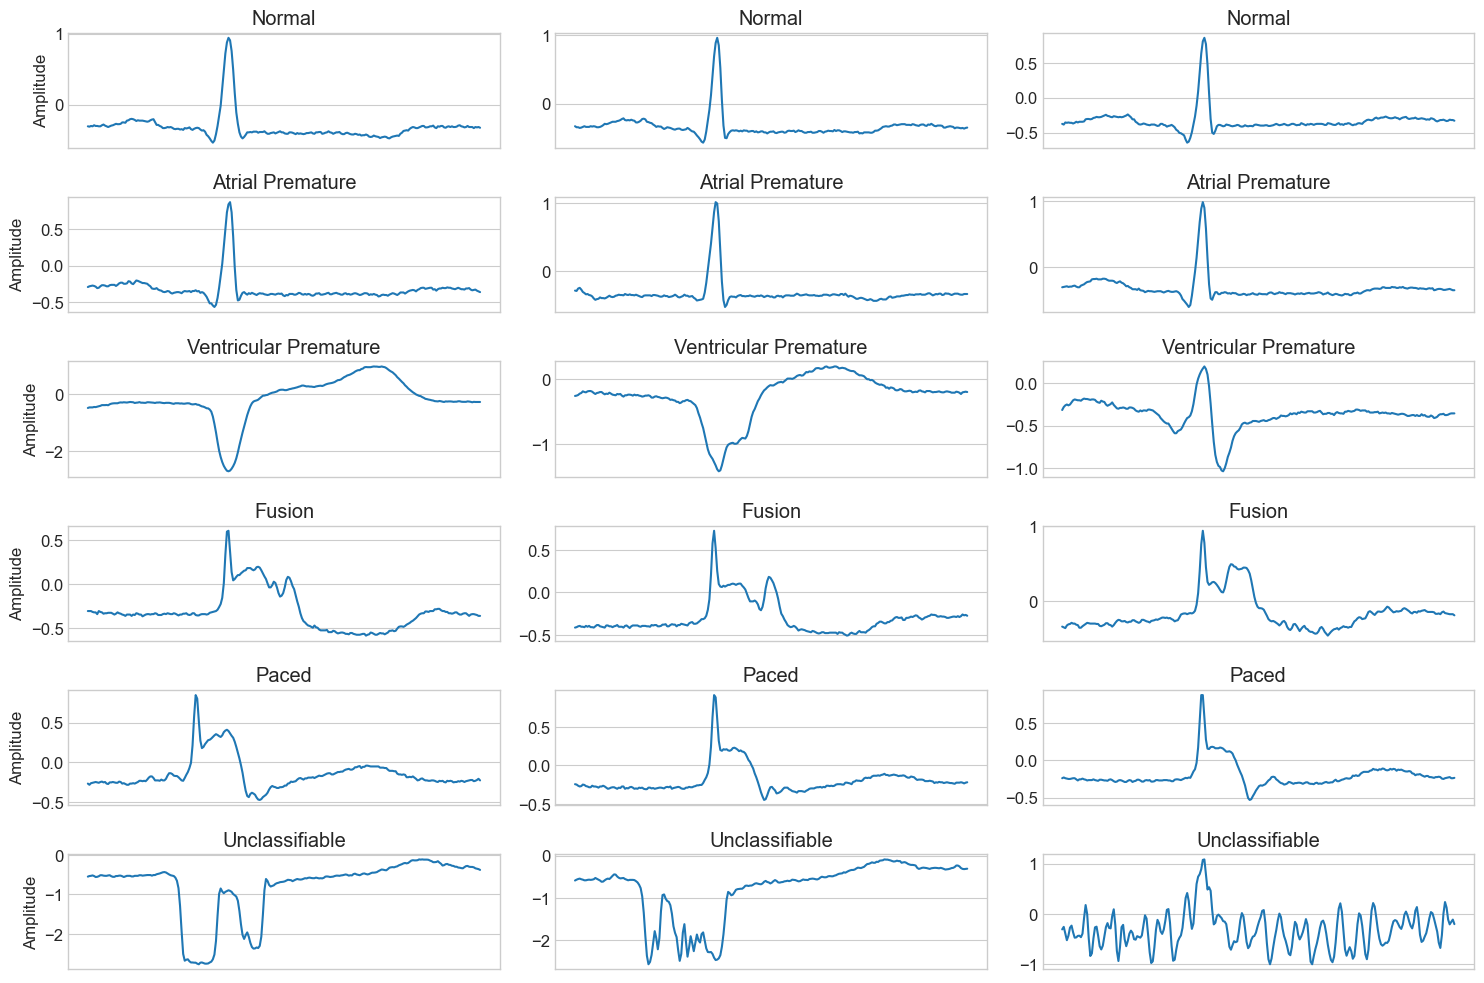

In [6]:
# %% Cell 4: Extract Labeled Heartbeats
# Extract heartbeats with labels
heartbeats, labels, label_names = arrhythmia_classifier.extract_labeled_heartbeats(record_data)

print(f"Extracted {len(heartbeats)} labeled heartbeats")
print(f"Label distribution: {Counter(labels)}")

# Plot class distribution
plt.figure(figsize=(10, 6))
unique_labels, counts = np.unique(labels, return_counts=True)
plt.bar([label_names[label] for label in unique_labels], counts, color='skyblue')
plt.title('Distribution of Heartbeat Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot a few example heartbeats from each class
plt.figure(figsize=(15, 10))
num_classes = len(unique_labels)
num_examples = min(3, min(counts))  # Show up to 3 examples per class

for i, label_id in enumerate(unique_labels):
    class_indices = np.where(labels == label_id)[0]
    
    for j in range(num_examples):
        plt.subplot(num_classes, num_examples, i*num_examples + j + 1)
        plt.plot(heartbeats[class_indices[j]])
        plt.title(f"{label_names[label_id]}")
        plt.xticks([])
        if j == 0:
            plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


Processed 500/109452 heartbeats...
Processed 1000/109452 heartbeats...
Processed 1500/109452 heartbeats...
Processed 2000/109452 heartbeats...
Processed 2500/109452 heartbeats...
Processed 3000/109452 heartbeats...
Processed 3500/109452 heartbeats...
Processed 4000/109452 heartbeats...
Processed 4500/109452 heartbeats...
Processed 5000/109452 heartbeats...
Processed 5500/109452 heartbeats...
Processed 6000/109452 heartbeats...
Processed 6500/109452 heartbeats...
Processed 7000/109452 heartbeats...
Processed 7500/109452 heartbeats...
Processed 8000/109452 heartbeats...
Processed 8500/109452 heartbeats...
Processed 9000/109452 heartbeats...
Processed 9500/109452 heartbeats...
Processed 10000/109452 heartbeats...
Processed 10500/109452 heartbeats...
Processed 11000/109452 heartbeats...
Processed 11500/109452 heartbeats...
Processed 12000/109452 heartbeats...
Processed 12500/109452 heartbeats...
Processed 13000/109452 heartbeats...
Processed 13500/109452 heartbeats...
Processed 14000/10945

,mean,std,min,max,range,median,rms,skewness,kurtosis,p5,...,qrs_interval,qt_interval,st_interval,p_q_slope,q_r_slope,r_s_slope,s_t_slope,r_prominence,p_prominence,t_prominence
0,-0.316746,0.200791,-0.535,0.940,1.475,-0.3425,0.375027,4.455601,21.998465,-0.45500,...,0.072,0.368,0.296,-13.500000,0.113636,-0.357143,0.304054,0.010,1.475,0.150
1,-0.332004,0.182994,-0.570,0.960,1.530,-0.3600,0.379095,5.036398,28.624437,-0.43225,...,0.024,0.320,0.296,-10.898438,2.083333,-1.666667,0.371622,0.025,1.530,0.115
2,-0.330615,0.173628,-0.645,0.860,1.505,-0.3700,0.373434,4.742695,26.679341,-0.46675,...,0.068,0.364,0.296,-13.281250,0.454545,-0.416667,0.422297,0.020,1.505,0.125
3,-0.336806,0.164246,-0.565,0.820,1.385,-0.3650,0.374719,4.897502,28.001843,-0.45000,...,0.024,0.320,0.296,-9.431818,2.500000,-2.500000,0.320946,0.030,1.385,0.140
4,-0.325774,0.174961,-0.545,0.885,1.430,-0.3525,0.369784,4.677205,25.848184,-0.44500,...,0.048,0.344,0.296,-13.000000,0.113636,-1.250000,0.270270,0.005,1.430,0.115


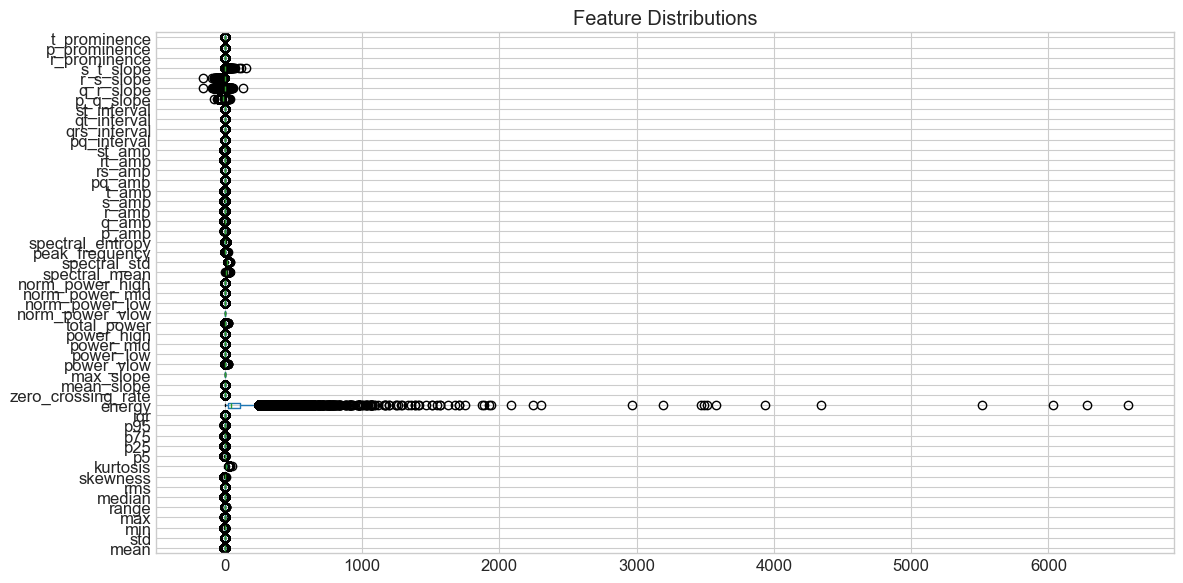

In [7]:
# %% Cell 5: Feature Extraction for Classification
# Extract features from heartbeats
features_df = arrhythmia_classifier.extract_features_for_classification(heartbeats, feature_extraction)

print(f"Extracted {features_df.shape[1]} features from {features_df.shape[0]} heartbeats")

# Display first few rows
display(features_df.head())

# Analyze feature statistics
plt.figure(figsize=(12, 6))
features_df.boxplot(vert=False, figsize=(12, 10))
plt.title('Feature Distributions')
plt.tight_layout()
plt.show()

Random Forest Accuracy: 0.9771
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     22649
           1       0.83      0.69      0.75       695
           2       0.94      0.93      0.94      1809
           3       0.93      0.80      0.86       446
           4       0.99      1.00      0.99      1756
           5       0.40      0.25      0.31         8

    accuracy                           0.98     27363
   macro avg       0.85      0.78      0.81     27363
weighted avg       0.98      0.98      0.98     27363

SVM Accuracy: 0.9521
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     22649
           1       0.40      0.88      0.55       695
           2       0.93      0.96      0.95      1809
           3       0.78      0.92      0.85       446
           4       1.00      1.00      1.00      1756
           5       0.00      0.00 

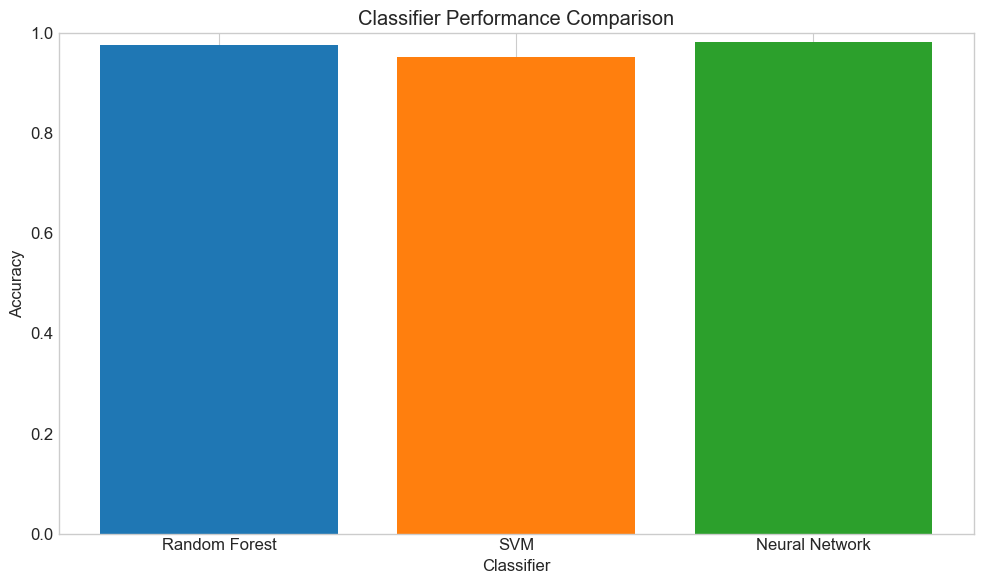

In [8]:
# %% Cell 6: Train Basic Classifiers
# Train Random Forest classifier
rf_model, rf_scaler, rf_accuracy, rf_report = arrhythmia_classifier.train_arrhythmia_classifier(
    features_df, labels, model_type='random_forest'
)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("Classification Report:")
print(rf_report)

# Train SVM classifier
svm_model, svm_scaler, svm_accuracy, svm_report = arrhythmia_classifier.train_arrhythmia_classifier(
    features_df, labels, model_type='svm'
)

print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("Classification Report:")
print(svm_report)

# Train Neural Network classifier
nn_model, nn_scaler, nn_accuracy, nn_report = arrhythmia_classifier.train_arrhythmia_classifier(
    features_df, labels, model_type='neural_network'
)

print(f"Neural Network Accuracy: {nn_accuracy:.4f}")
print("Classification Report:")
print(nn_report)

# Compare classifier performance
models = ['Random Forest', 'SVM', 'Neural Network']
accuracies = [rf_accuracy, svm_accuracy, nn_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Classifier Performance Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Ensemble Classifier Accuracy: 0.9837
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     22649
           1       0.92      0.72      0.81       695
           2       0.97      0.95      0.96      1809
           3       0.93      0.85      0.89       446
           4       0.99      1.00      0.99      1756
           5       0.50      0.12      0.20         8

    accuracy                           0.98     27363
   macro avg       0.88      0.77      0.81     27363
weighted avg       0.98      0.98      0.98     27363



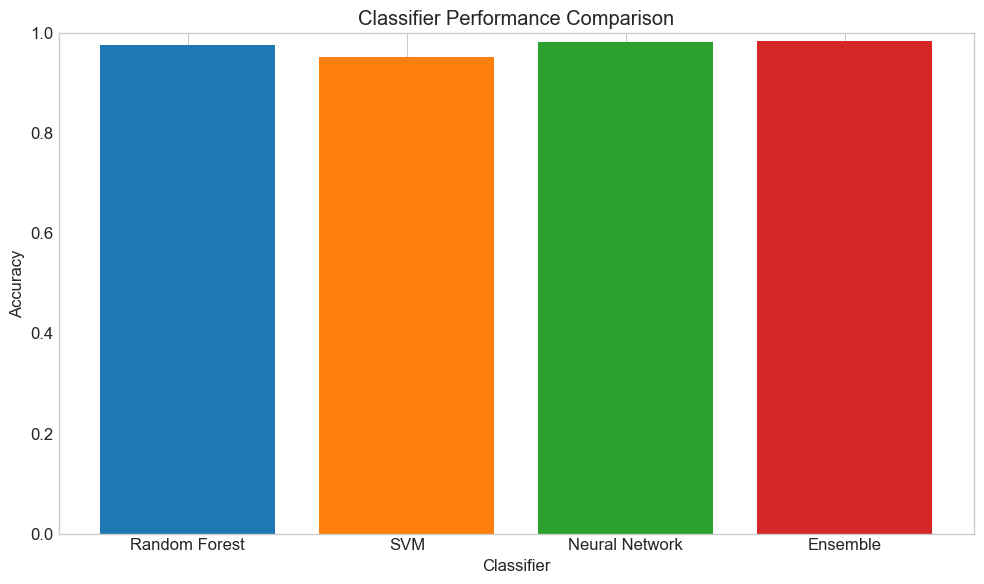

In [9]:
# %% Cell 7: Advanced Ensemble Classifier
# Create output directory for models
models_dir = '../models/saved'
os.makedirs(models_dir, exist_ok=True)

# Build advanced ensemble classifier
ensemble_model, ensemble_label_names, ensemble_accuracy, ensemble_report = arrhythmia_classifier.build_advanced_ensemble_classifier(
    features_df, labels, models_dir
)

print(f"Ensemble Classifier Accuracy: {ensemble_accuracy:.4f}")
print("Classification Report:")
print(ensemble_report)

# Compare with individual classifiers
models = ['Random Forest', 'SVM', 'Neural Network', 'Ensemble']
accuracies = [rf_accuracy, svm_accuracy, nn_accuracy, ensemble_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Classifier Performance Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


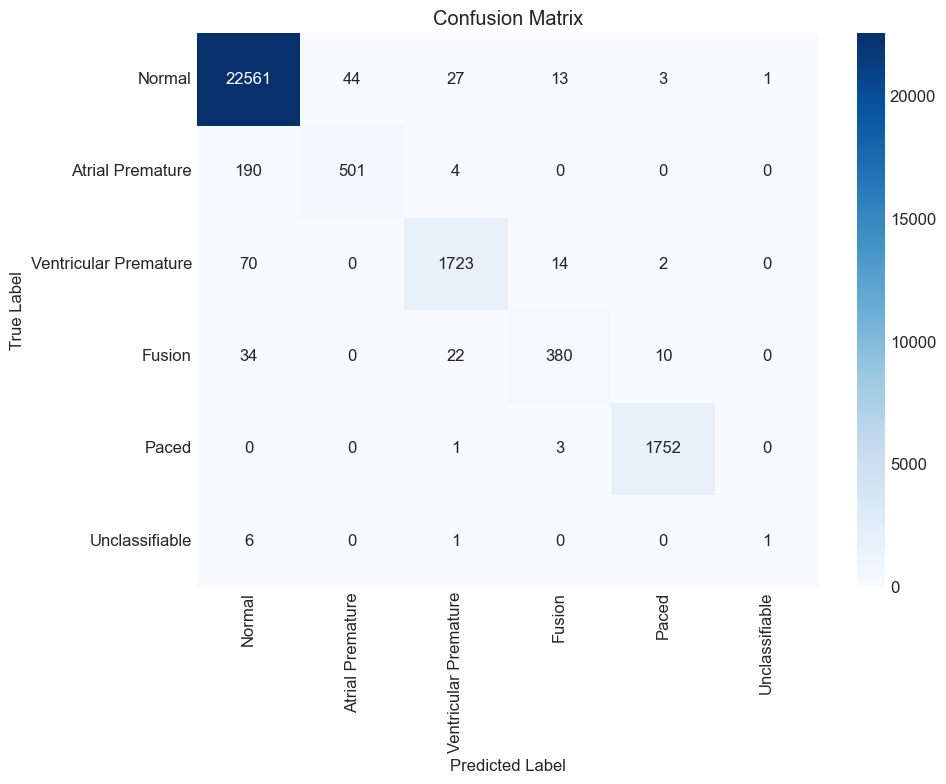

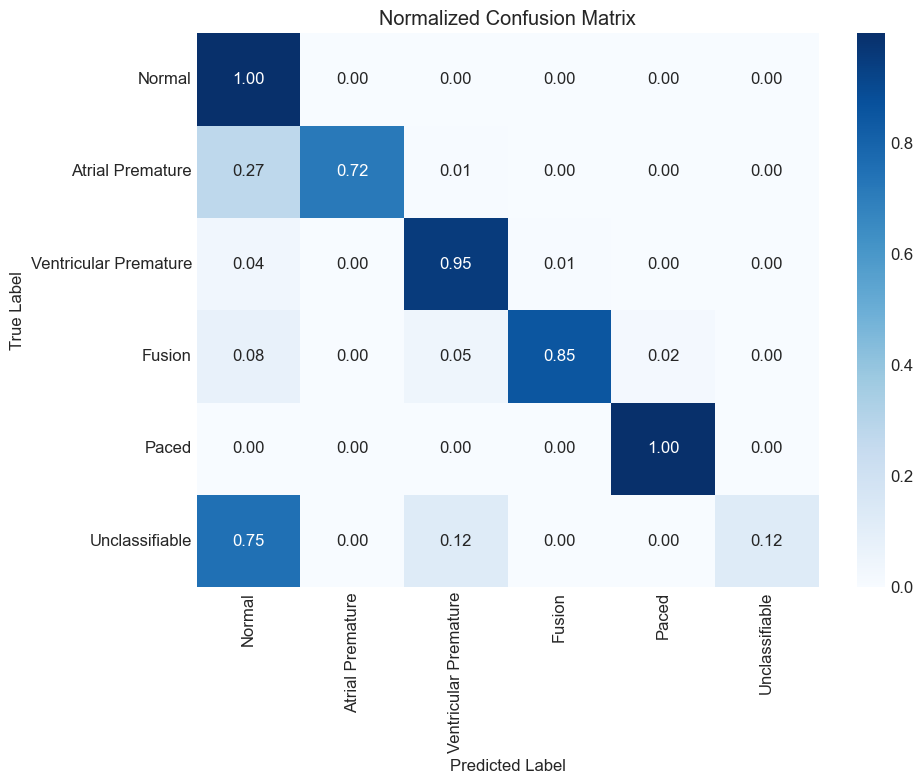

In [10]:
# %% Cell 8: Confusion Matrix Analysis
# Get predictions from ensemble model
X_train, X_test, y_train, y_test = train_test_split(
    features_df, labels, test_size=0.25, random_state=42, stratify=labels
)
y_pred = ensemble_model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_names[i] for i in sorted(label_names.keys())],
            yticklabels=[label_names[i] for i in sorted(label_names.keys())])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Normalize confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[label_names[i] for i in sorted(label_names.keys())],
            yticklabels=[label_names[i] for i in sorted(label_names.keys())])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

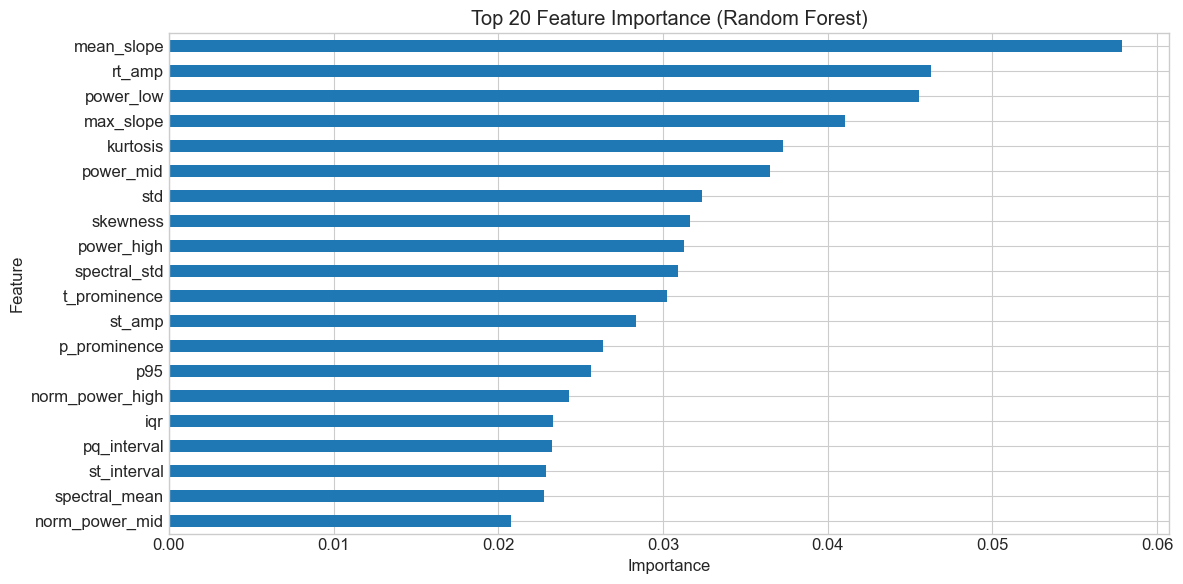

Top 10 Most Important Features:


,Feature,Importance
16,mean_slope,0.057847
38,rt_amp,0.046255
19,power_low,0.045559
17,max_slope,0.041049
8,kurtosis,0.037319
20,power_mid,0.036477
1,std,0.032350
7,skewness,0.031663
21,power_high,0.031273
28,spectral_std,0.030906


In [11]:
# %% Cell 9: Feature Importance Analysis
# Get feature importance from Random Forest model
if hasattr(rf_model, 'feature_importances_'):
    # Get feature importances
    importances = rf_model.feature_importances_
    
    # Create DataFrame with feature names and importances
    importance_df = pd.DataFrame({
        'Feature': features_df.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    importance_df.head(20).sort_values('Importance').plot(
        kind='barh', x='Feature', y='Importance', legend=False)
    plt.title('Top 20 Feature Importance (Random Forest)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Print top 10 features
    print("Top 10 Most Important Features:")
    display(importance_df.head(10))


In [13]:
# %% Cell 10: Save and Load Classifiers (Fixed)
# Create classification pipelines
rf_pipeline = arrhythmia_classifier.create_classification_pipeline(rf_model, rf_scaler)
svm_pipeline = arrhythmia_classifier.create_classification_pipeline(svm_model, svm_scaler)
nn_pipeline = arrhythmia_classifier.create_classification_pipeline(nn_model, nn_scaler)

# Save the pipelines
rf_path = arrhythmia_classifier.save_classifier(rf_pipeline, label_names, 
                                               os.path.join(models_dir, 'random_forest'))
svm_path = arrhythmia_classifier.save_classifier(svm_pipeline, label_names, 
                                                os.path.join(models_dir, 'svm'))
nn_path = arrhythmia_classifier.save_classifier(nn_pipeline, label_names, 
                                               os.path.join(models_dir, 'neural_network'))

print(f"Saved Random Forest model to: {rf_path}")
print(f"Saved SVM model to: {svm_path}")
print(f"Saved Neural Network model to: {nn_path}")

# Load and test a classifier
loaded_pipeline, loaded_label_names = arrhythmia_classifier.load_classifier(os.path.join(models_dir, 'random_forest'))

# Test on a few examples - FIXED VERSION
test_indices = []
for i in range(len(label_names)):
    # Get indices where labels match class i
    class_indices = np.where(labels == i)[0]
    # Only add if this class has examples
    if len(class_indices) > 0:
        test_indices.append(np.random.choice(class_indices))

# Only proceed if we have test examples
if len(test_indices) > 0:
    test_heartbeats = heartbeats[test_indices]
    
    for i, heartbeat in enumerate(test_heartbeats):
        class_id, class_name, probs = arrhythmia_classifier.classify_heartbeat(
            heartbeat, loaded_pipeline, feature_extraction, loaded_label_names
        )
        
        print(f"Heartbeat {i+1}:")
        print(f"  True class: {label_names[labels[test_indices[i]]]}")
        print(f"  Predicted class: {class_name}")
        print(f"  Confidence: {max(probs) if probs is not None else 'N/A':.2f}")
        print()
else:
    print("No test examples available for classification.")

Saved Random Forest model to: ../models/saved\random_forest\arrhythmia_classifier.pkl
Saved SVM model to: ../models/saved\svm\arrhythmia_classifier.pkl
Saved Neural Network model to: ../models/saved\neural_network\arrhythmia_classifier.pkl
Heartbeat 1:
  True class: Normal
  Predicted class: Normal
  Confidence: 0.96

Heartbeat 2:
  True class: Atrial Premature
  Predicted class: Atrial Premature
  Confidence: 0.95

Heartbeat 3:
  True class: Ventricular Premature
  Predicted class: Ventricular Premature
  Confidence: 1.00

Heartbeat 4:
  True class: Fusion
  Predicted class: Fusion
  Confidence: 0.87

Heartbeat 5:
  True class: Paced
  Predicted class: Paced
  Confidence: 0.99

Heartbeat 6:
  True class: Unclassifiable
  Predicted class: Unclassifiable
  Confidence: 0.64



Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


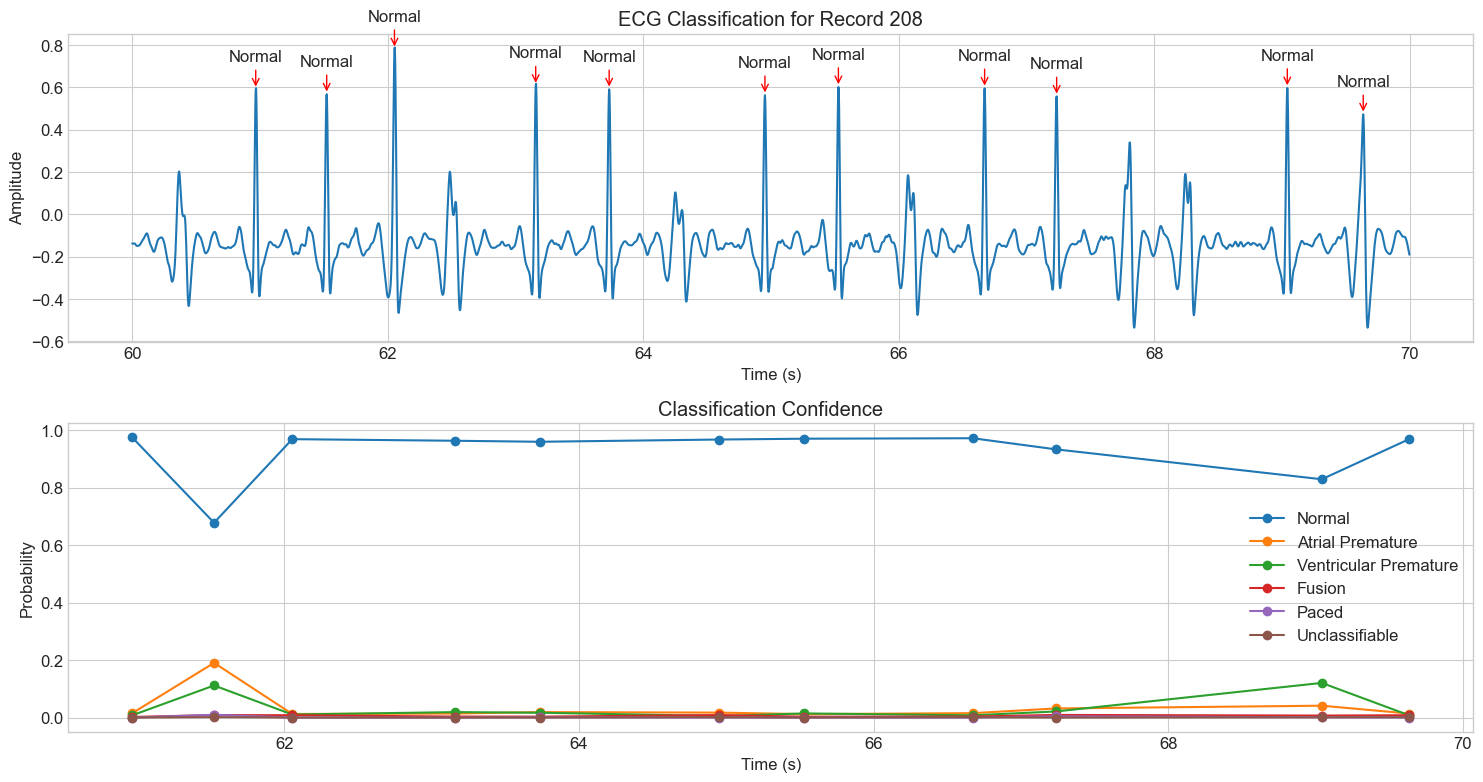

Classification accuracy for record 208: 0.7449


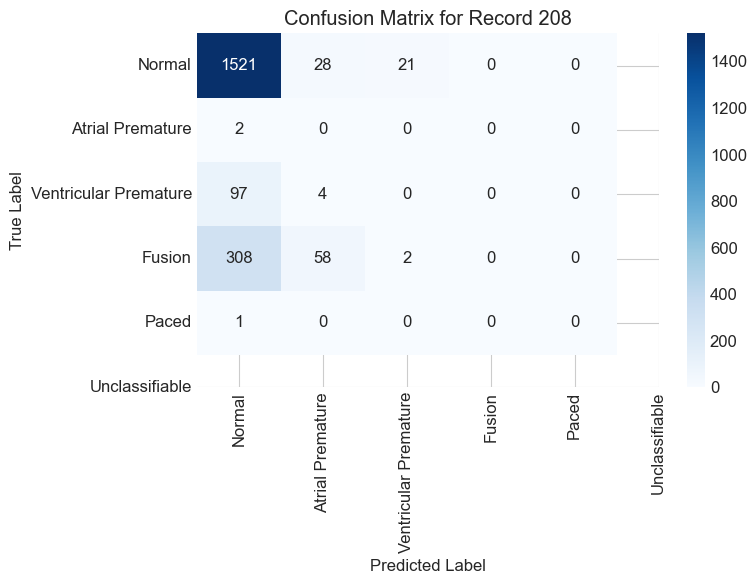

In [15]:
# %% Cell 11: Simulate Real-Time Classification (Fixed)
# Select a record with various arrhythmias for testing
test_record_name = '208'  # Record with multiple arrhythmia types
if test_record_name in record_data:
    test_record = record_data[test_record_name]
    signal = test_record['signal']
    fs = test_record['fs']
    annotation = test_record['annotation']
    
    # Process the signal
    processed_signal = data_processing.preprocess_ecg(signal, fs)
    
    # Detect R-peaks
    r_peaks = peak_detection.detect_r_peaks(processed_signal[:, 0], fs)
    
    # Extract heartbeats
    window_params = {'before_r': 0.25, 'after_r': 0.45}
    extracted_beats = data_processing.extract_heartbeat_segments(
        processed_signal[:, 0], r_peaks, fs, 
        before_r=window_params['before_r'], 
        after_r=window_params['after_r']
    )
    
    # Load the ensemble classifier
    ensemble_pipeline, ensemble_label_names = arrhythmia_classifier.load_classifier(models_dir)
    
    # Classify heartbeats
    class_ids, class_names, probabilities = arrhythmia_classifier.classify_multiple_heartbeats(
        extracted_beats, ensemble_pipeline, feature_extraction, ensemble_label_names
    )
    
    # Get ground truth from annotations - FIXED VERSION
    true_classes = []
    valid_indices = []  # Keep track of which detected beats have valid annotations
    
    for i, r_peak in enumerate(r_peaks):
        if i < len(extracted_beats):  # Make sure we only process valid extracted beats
            # Find closest annotation
            closest_distances = np.abs(annotation.sample - r_peak)
            closest_idx = np.argmin(closest_distances)
            
            # Only consider annotations within 50ms (or appropriate threshold)
            if closest_distances[closest_idx] <= int(0.05 * fs):  # 50ms threshold
                symbol = annotation.symbol[closest_idx]
                
                # Map to class
                if symbol in arrhythmia_classifier.AAMI_MAPPING:
                    class_name = arrhythmia_classifier.AAMI_MAPPING[symbol]
                    class_id = arrhythmia_classifier.SIMPLIFIED_CLASSES[class_name]
                    true_classes.append(class_id)
                    valid_indices.append(i)
                else:
                    true_classes.append(-1)  # Unknown
                    valid_indices.append(i)
    
    # Make sure we only use classified beats that have corresponding annotations
    valid_class_ids = [class_ids[i] for i in valid_indices if i < len(class_ids)]
    valid_true_classes = [true_classes[i] for i in range(len(valid_indices)) if valid_indices[i] < len(class_ids)]
    
    # Plot a segment of the signal with classification results
    segment_duration = 10  # seconds
    start_time = 60  # seconds
    start_sample = int(start_time * fs)
    end_sample = int((start_time + segment_duration) * fs)
    
    plt.figure(figsize=(15, 8))
    
    # Plot the ECG signal
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(start_sample, end_sample) / fs, processed_signal[start_sample:end_sample, 0])
    
    # Mark R-peaks and classifications
    r_peaks_in_segment = r_peaks[(r_peaks >= start_sample) & (r_peaks < end_sample)]
    
    for r_peak in r_peaks_in_segment:
        # Find index in r_peaks array
        peak_idx = np.where(r_peaks == r_peak)[0][0]
        
        # Check if this index is in our valid indices and within bounds of class_names
        if peak_idx in valid_indices and peak_idx < len(class_names):
            class_name = class_names[peak_idx]
            plt.annotate(class_name, (r_peak/fs, processed_signal[r_peak, 0]),
                        xytext=(0, 20), textcoords='offset points',
                        arrowprops=dict(arrowstyle='->', color='red'),
                        ha='center')
    
    plt.title(f'ECG Classification for Record {test_record_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # Plot classification confidence
    plt.subplot(2, 1, 2)
    if probabilities is not None:
        for class_idx in range(probabilities.shape[1]):  # For each class
            class_label = ensemble_label_names[class_idx]
            
            # Plot confidence only for peaks in segment that are valid
            valid_peaks_in_segment = []
            valid_probs = []
            
            for i, r_peak in enumerate(r_peaks_in_segment):
                peak_idx = np.where(r_peaks == r_peak)[0][0]
                if peak_idx in valid_indices and peak_idx < len(probabilities):
                    valid_peaks_in_segment.append(r_peak)
                    valid_probs.append(probabilities[peak_idx][class_idx])
            
            if valid_peaks_in_segment:
                plt.plot([r_peak/fs for r_peak in valid_peaks_in_segment], 
                        valid_probs, 'o-', label=class_label)
        
        plt.title('Classification Confidence')
        plt.xlabel('Time (s)')
        plt.ylabel('Probability')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate accuracy for this record
    if len(valid_true_classes) > 0 and len(valid_class_ids) == len(valid_true_classes):
        # Filter out unknown classes
        matched_true_classes = [c for c in valid_true_classes if c != -1]
        matched_pred_classes = [valid_class_ids[i] for i, c in enumerate(valid_true_classes) if c != -1]
        
        if matched_true_classes:
            accuracy = accuracy_score(matched_true_classes, matched_pred_classes)
            print(f"Classification accuracy for record {test_record_name}: {accuracy:.4f}")
            
            # Display confusion matrix
            cm = confusion_matrix(matched_true_classes, matched_pred_classes)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=[ensemble_label_names[i] for i in sorted(ensemble_label_names.keys())],
                       yticklabels=[ensemble_label_names[i] for i in sorted(ensemble_label_names.keys())])
            plt.title(f'Confusion Matrix for Record {test_record_name}')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.tight_layout()
            plt.show()
    else:
        print(f"No matching annotations found for record {test_record_name}")
    
else:
    print(f"Record {test_record_name} not found in the dataset")

Extracting features for cross-validation...
Processed 500/109452 heartbeats...
Processed 1000/109452 heartbeats...
Processed 1500/109452 heartbeats...
Processed 2000/109452 heartbeats...
Processed 2500/109452 heartbeats...
Processed 3000/109452 heartbeats...
Processed 3500/109452 heartbeats...
Processed 4000/109452 heartbeats...
Processed 4500/109452 heartbeats...
Processed 5000/109452 heartbeats...
Processed 5500/109452 heartbeats...
Processed 6000/109452 heartbeats...
Processed 6500/109452 heartbeats...
Processed 7000/109452 heartbeats...
Processed 7500/109452 heartbeats...
Processed 8000/109452 heartbeats...
Processed 8500/109452 heartbeats...
Processed 9000/109452 heartbeats...
Processed 9500/109452 heartbeats...
Processed 10000/109452 heartbeats...
Processed 10500/109452 heartbeats...
Processed 11000/109452 heartbeats...
Processed 11500/109452 heartbeats...
Processed 12000/109452 heartbeats...
Processed 12500/109452 heartbeats...
Processed 13000/109452 heartbeats...
Processed 1350

C:\Users\monib\Desktop\ECG_Analysis\ECG_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\monib\Desktop\ECG_Analysis\ECG_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\monib\Desktop\ECG_Analysis\ECG_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

  Test records: ['104' '112' '113' '114' '123' '202' '203' '208' '220' '221']
  Test accuracy: 0.8971
  Test F1 score: 0.8761

Cross-Validation Results:
Mean accuracy: 0.8308 ± 0.0918
Mean F1 score: 0.8135 ± 0.1018


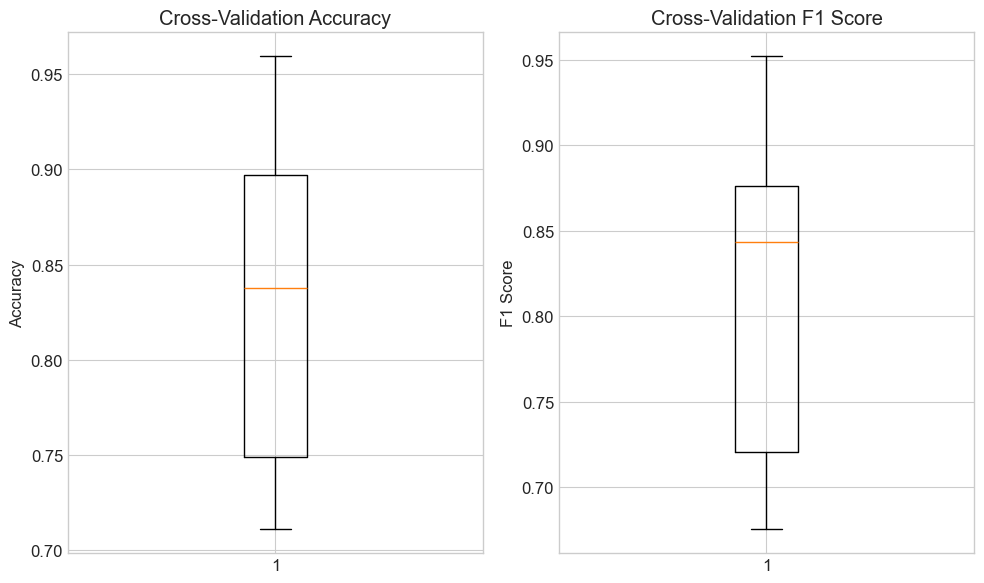

In [16]:
# %% Cell 12: Cross-Validation Across Records
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, f1_score

# Prepare groups (record IDs) for cross-validation
record_ids = []
record_heartbeats = []
record_labels = []

for record_name, data in record_data.items():
    if 'annotation' not in data or data['annotation'] is None:
        continue
        
    # Get signal and annotation
    signal = data['signal']
    annotation = data['annotation']
    fs = data['fs']
    
    # Process signal
    processed_signal = data_processing.preprocess_ecg(signal, fs)
    
    # Extract beats and labels
    heartbeats, labels, _ = arrhythmia_classifier.extract_labeled_heartbeats(
        {record_name: data}, before_r=0.25, after_r=0.45
    )
    
    # Store record ID for each beat
    record_ids.extend([record_name] * len(heartbeats))
    record_heartbeats.append(heartbeats)
    record_labels.append(labels)

# Combine all heartbeats and labels
all_heartbeats = np.vstack(record_heartbeats)
all_labels = np.concatenate(record_labels)
all_record_ids = np.array(record_ids)

# Extract features
print("Extracting features for cross-validation...")
cv_features = arrhythmia_classifier.extract_features_for_classification(all_heartbeats, feature_extraction)

# Perform cross-validation
n_splits = 5
group_kfold = GroupKFold(n_splits=n_splits)

cv_accuracies = []
cv_f1_scores = []

print(f"Performing {n_splits}-fold cross-validation across records...")
for fold, (train_idx, test_idx) in enumerate(group_kfold.split(cv_features, all_labels, all_record_ids)):
    print(f"Fold {fold+1}/{n_splits}:")
    
    # Split data
    X_train, X_test = cv_features.iloc[train_idx], cv_features.iloc[test_idx]
    y_train, y_test = all_labels[train_idx], all_labels[test_idx]
    
    # Train Random Forest (quickest to train)
    model, scaler, accuracy, _ = arrhythmia_classifier.train_arrhythmia_classifier(
        X_train, y_train, model_type='random_forest'
    )
    
    # Create pipeline
    pipeline = arrhythmia_classifier.create_classification_pipeline(model, scaler)
    
    # Predict on test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    
    cv_accuracies.append(test_accuracy)
    cv_f1_scores.append(test_f1)
    
    print(f"  Test records: {np.unique(all_record_ids[test_idx])}")
    print(f"  Test accuracy: {test_accuracy:.4f}")
    print(f"  Test F1 score: {test_f1:.4f}")

# Print cross-validation results
print("\nCross-Validation Results:")
print(f"Mean accuracy: {np.mean(cv_accuracies):.4f} ± {np.std(cv_accuracies):.4f}")
print(f"Mean F1 score: {np.mean(cv_f1_scores):.4f} ± {np.std(cv_f1_scores):.4f}")

# Plot cross-validation results
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.boxplot(cv_accuracies)
plt.title('Cross-Validation Accuracy')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(cv_f1_scores)
plt.title('Cross-Validation F1 Score')
plt.ylabel('F1 Score')
plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
# %% Cell 13: Final Model Training
# Train on the entire dataset
print("Training final model on the entire dataset...")
final_model, final_scaler, final_accuracy, final_report = arrhythmia_classifier.train_arrhythmia_classifier(
    cv_features, all_labels, model_type='random_forest'
)

print(f"Final Model Accuracy: {final_accuracy:.4f}")
print("Classification Report:")
print(final_report)

# Create and save the final pipeline
final_pipeline = arrhythmia_classifier.create_classification_pipeline(final_model, final_scaler)
final_path = arrhythmia_classifier.save_classifier(
    final_pipeline, {v: k for k, v in arrhythmia_classifier.SIMPLIFIED_CLASSES.items()}, 
    os.path.join(models_dir, 'final_model')
)

print(f"Saved final model to: {final_path}")

Training final model on the entire dataset...
Final Model Accuracy: 0.9771
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     22649
           1       0.83      0.69      0.75       695
           2       0.94      0.93      0.94      1809
           3       0.93      0.80      0.86       446
           4       0.99      1.00      0.99      1756
           5       0.40      0.25      0.31         8

    accuracy                           0.98     27363
   macro avg       0.85      0.78      0.81     27363
weighted avg       0.98      0.98      0.98     27363

Saved final model to: ../models/saved\final_model\arrhythmia_classifier.pkl


<Figure size 1200x800 with 0 Axes>

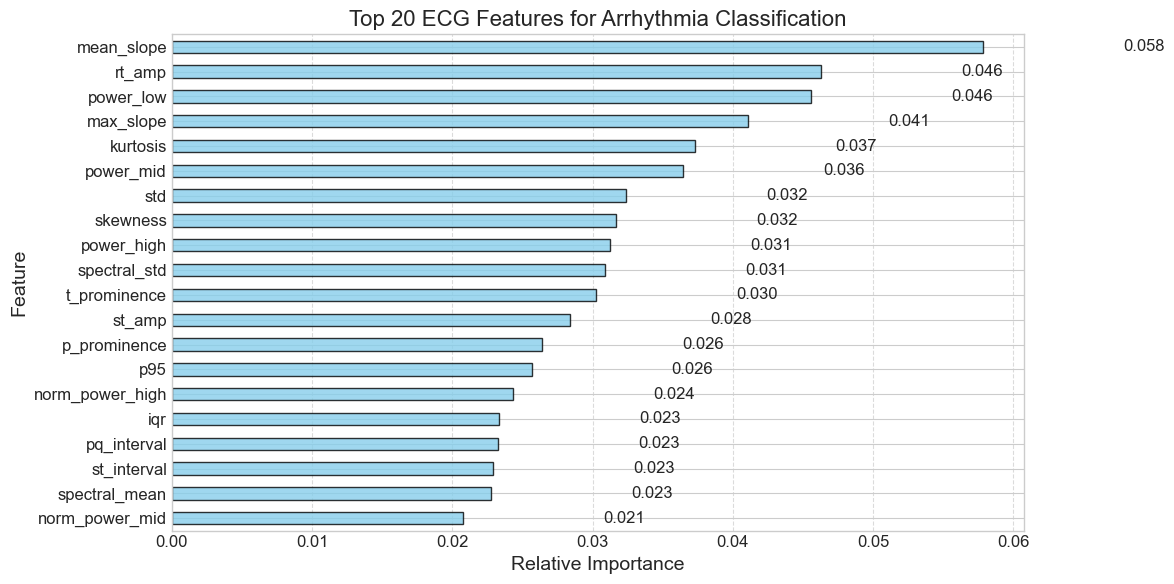

In [18]:
# %% Cell 14: Generate Feature Importance Visualization for Publication
if hasattr(final_model, 'feature_importances_'):
    # Get feature importances
    importances = final_model.feature_importances_
    
    # Create DataFrame with feature names and importances
    importance_df = pd.DataFrame({
        'Feature': cv_features.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot top 20 features with a more publication-quality style
    plt.figure(figsize=(12, 8))
    ax = importance_df.head(20).sort_values('Importance').plot(
        kind='barh', x='Feature', y='Importance', legend=False,
        color='skyblue', edgecolor='black', alpha=0.8
    )
    
    # Add data values to the end of each bar
    for i, v in enumerate(importance_df.head(20).sort_values('Importance')['Importance']):
        ax.text(v + 0.01, i, f"{v:.3f}", va='center')
    
    plt.title('Top 20 ECG Features for Arrhythmia Classification', fontsize=16)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save figure
    output_dir = '../docs/paper'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, 'feature_importance.png'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(output_dir, 'feature_importance.pdf'), bbox_inches='tight')
    
    plt.show()
